In [1]:
# Import necessary libraries
import pandas as pd

# Define file paths (using your specific path)
files = {
    "attacking_data": r"C:\Users\heelt\Downloads\Kaggle Projet\DAY_4\attacking_data.csv",
    "attempts_data": r"C:\Users\heelt\Downloads\Kaggle Projet\DAY_4\attempts_data.csv",
    "defending_data": r"C:\Users\heelt\Downloads\Kaggle Projet\DAY_4\defending_data.csv",
    "disciplinary_data": r"C:\Users\heelt\Downloads\Kaggle Projet\DAY_4\disciplinary_data.csv",
    "distribution_data": r"C:\Users\heelt\Downloads\Kaggle Projet\DAY_4\distribution_data.csv",
    "goalkeeping_data": r"C:\Users\heelt\Downloads\Kaggle Projet\DAY_4\goalkeeping_data.csv",
    "goals_data": r"C:\Users\heelt\Downloads\Kaggle Projet\DAY_4\goals_data.csv",
    "key_stats_data": r"C:\Users\heelt\Downloads\Kaggle Projet\DAY_4\key_stats_data.csv",
    "players_data": r"C:\Users\heelt\Downloads\Kaggle Projet\DAY_4\players_data.csv",
    "teams_data": r"C:\Users\heelt\Downloads\Kaggle Projet\DAY_4\teams_data.csv"
}

# Load all datasets into a dictionary of DataFrames
dataframes = {name: pd.read_csv(path) for name, path in files.items()}

# Display an overview of each dataset
for name, df in dataframes.items():
    print(f"\n--- {name} ---")
    print(f"Columns: {df.columns.tolist()}")
    print(f"Data Types:\n{df.dtypes}")
    print(f"Missing Values:\n{df.isnull().sum()}")
    print(f"Sample Data:\n{df.head()}")



--- attacking_data ---
Columns: ['id_player', 'assists', 'corners_taken', 'offsides', 'dribbles']
Data Types:
id_player          int64
assists          float64
corners_taken    float64
offsides         float64
dribbles         float64
dtype: object
Missing Values:
id_player          0
assists          181
corners_taken    181
offsides         181
dribbles         181
dtype: int64
Sample Data:
   id_player  assists  corners_taken  offsides  dribbles
0  250052469      4.0            0.0       1.0       9.0
1  250130414      3.0           21.0       0.0       2.0
2  250070417      3.0           19.0       0.0       0.0
3  250112880      3.0           12.0       2.0       7.0
4  250177886      3.0            8.0       0.0       5.0

--- attempts_data ---
Columns: ['id_player', 'total_attempts', 'attempts_on_target', 'attempts_off_target', 'blocked']
Data Types:
id_player                int64
total_attempts         float64
attempts_on_target     float64
attempts_off_target    float64
block

In [2]:
# Step 1: Data Cleaning

# 1. Remove redundant columns (e.g., 'Unnamed: 0' in disciplinary_data)
if 'Unnamed: 0' in dataframes['disciplinary_data'].columns:
    dataframes['disciplinary_data'] = dataframes['disciplinary_data'].drop(columns=['Unnamed: 0'])

# 2. Handle missing values for players_data
players_df = dataframes['players_data']

# Fill height and weight with their median values
players_df['height(cm)'].fillna(players_df['height(cm)'].median(), inplace=True)
players_df['weight(kg)'].fillna(players_df['weight(kg)'].median(), inplace=True)

# Fill missing position with "UNKNOWN"
players_df['position'].fillna("UNKNOWN", inplace=True)

# Update the cleaned players_data in the dictionary
dataframes['players_data'] = players_df

# 3. Drop rows with excessive missing data in performance datasets
performance_keys = [
    'attacking_data',
    'attempts_data',
    'defending_data',
    'goalkeeping_data',
    'distribution_data',
    'goals_data',
    'key_stats_data'
]

# Set a threshold for acceptable missing values (e.g., drop rows with >50% missing values)
for key in performance_keys:
    df = dataframes[key]
    threshold = len(df.columns) // 2  # Allow up to 50% missing columns
    dataframes[key] = df.dropna(thresh=threshold)

# 4. Convert float columns (e.g., goals, assists) to integers where appropriate
for key in performance_keys:
    df = dataframes[key]
    cols_to_convert = df.select_dtypes(include='float').columns
    dataframes[key][cols_to_convert] = df[cols_to_convert].fillna(0).astype(int)

# 5. Verify the cleaning process
cleaned_summary = {
    name: {
        "rows_after_cleaning": len(df),
        "columns_after_cleaning": len(df.columns),
        "remaining_missing_values": df.isnull().sum().to_dict()
    }
    for name, df in dataframes.items()
}

# Display the cleaning summary
cleaned_summary_df = pd.DataFrame.from_dict(cleaned_summary, orient='index')
print("--- Data Cleaning Summary ---")
print(cleaned_summary_df)


--- Data Cleaning Summary ---
                   rows_after_cleaning  columns_after_cleaning  \
attacking_data                     727                       5   
attempts_data                      727                       5   
defending_data                     727                       6   
disciplinary_data                  908                       5   
distribution_data                  727                       9   
goalkeeping_data                   727                       6   
goals_data                         727                       9   
key_stats_data                     727                       5   
players_data                       908                      10   
teams_data                          36                       4   

                                            remaining_missing_values  
attacking_data     {'id_player': 0, 'assists': 0, 'corners_taken'...  
attempts_data      {'id_player': 0, 'total_attempts': 0, 'attempt...  
defending_data     {'id_player

In [3]:
# Step 2: Merging Datasets

# 1. Merge all player-level datasets on 'id_player'
player_level_data = dataframes['players_data']

# List of datasets to merge with players_data
datasets_to_merge = [
    'attacking_data',
    'attempts_data',
    'defending_data',
    'goalkeeping_data',
    'distribution_data',
    'goals_data',
    'key_stats_data'
]

# Merge iteratively
for dataset_name in datasets_to_merge:
    player_level_data = player_level_data.merge(
        dataframes[dataset_name],
        on='id_player',
        how='left'
    )

# 2. Merge team-level information
final_data = player_level_data.merge(
    dataframes['teams_data'],
    left_on='id_team',
    right_on='team_id',
    how='left'
)

# 3. Drop redundant columns and rename for clarity
final_data.drop(columns=['team_id'], inplace=True)

# Display the structure of the merged dataset
print("--- Final Merged Dataset ---")
print(final_data.info())
print(final_data.head())


--- Final Merged Dataset ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 908 entries, 0 to 907
Data columns (total 51 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id_player               908 non-null    int64  
 1   player_name             908 non-null    object 
 2   nationality             908 non-null    object 
 3   field_position          908 non-null    object 
 4   position                908 non-null    object 
 5   weight(kg)              908 non-null    float64
 6   height(cm)              908 non-null    float64
 7   age                     908 non-null    int64  
 8   id_team                 908 non-null    int64  
 9   player_image            908 non-null    object 
 10  assists                 727 non-null    float64
 11  corners_taken           727 non-null    float64
 12  offsides                727 non-null    float64
 13  dribbles                727 non-null    float64
 14  total_attempt

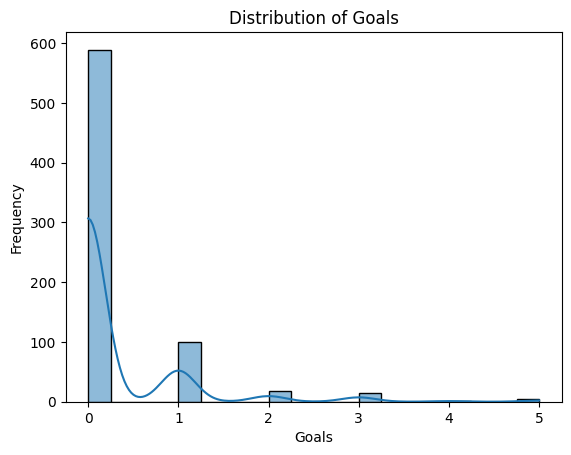

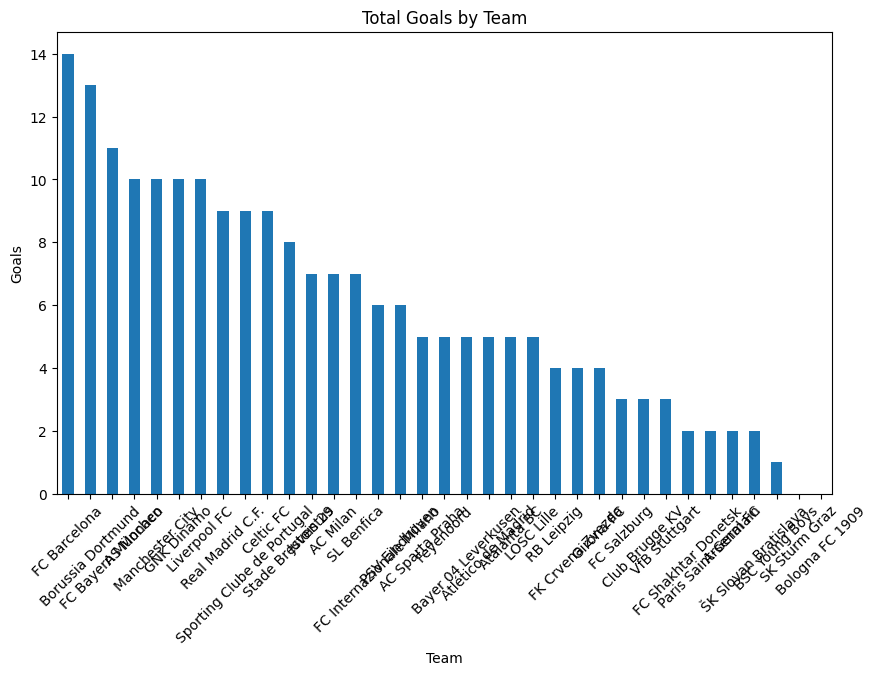

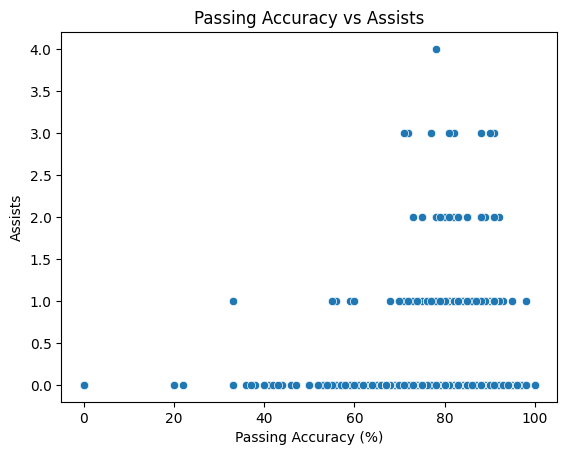

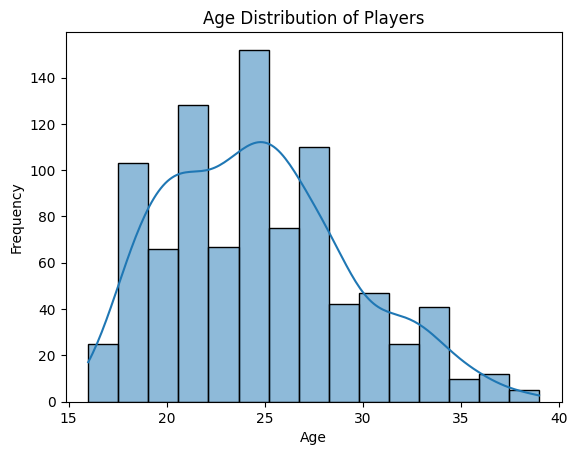

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Goals Distribution
sns.histplot(final_data['goals'].dropna(), kde=True, bins=20)
plt.title('Distribution of Goals')
plt.xlabel('Goals')
plt.ylabel('Frequency')
plt.show()

# 2. Team Performance: Total Goals by Team
team_goals = final_data.groupby('team')['goals'].sum().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
team_goals.plot(kind='bar')
plt.title('Total Goals by Team')
plt.xlabel('Team')
plt.ylabel('Goals')
plt.xticks(rotation=45)
plt.show()

# 3. Passing Accuracy vs. Assists
sns.scatterplot(x='passing_accuracy(%)', y='assists', data=final_data)
plt.title('Passing Accuracy vs Assists')
plt.xlabel('Passing Accuracy (%)')
plt.ylabel('Assists')
plt.show()

# 4. Age Distribution of Players
sns.histplot(final_data['age'], kde=True, bins=15)
plt.title('Age Distribution of Players')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()


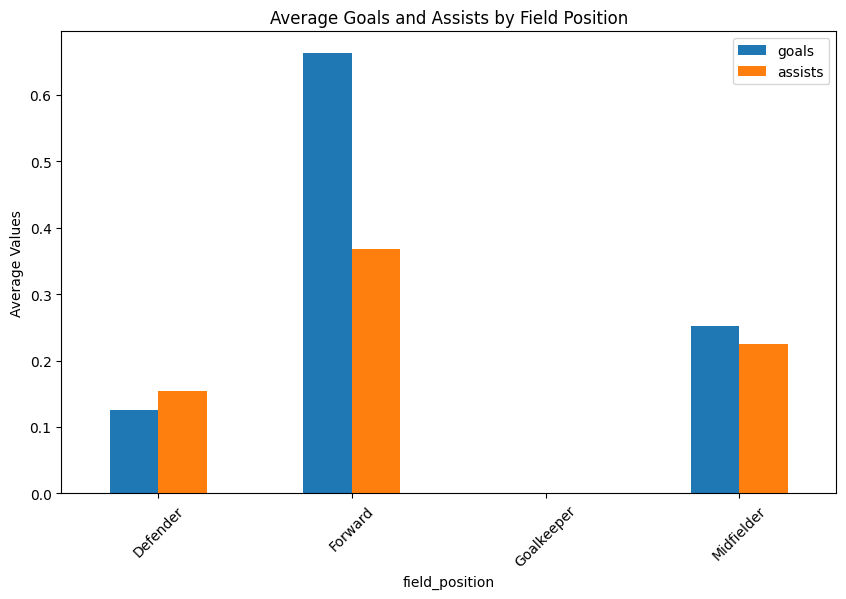

In [9]:
# Analyze metrics by field position (only goals and assists)
field_position_metrics = final_data.groupby('field_position')[['goals', 'assists']].mean()

# Visualize the metrics
field_position_metrics.plot(kind='bar', figsize=(10, 6), title='Average Goals and Assists by Field Position')
plt.ylabel('Average Values')
plt.xticks(rotation=45)
plt.show()



--- Top 10 Players by Total Contributions ---
            player_name                        team  goals  assists  \
155            Raphinha                FC Barcelona    5.0      3.0   
0            Harry Kane           FC Bayern München    5.0      1.0   
1       Viktor Gyökeres  Sporting Clube de Portugal    5.0      0.0   
126       Mohamed Salah                Liverpool FC    1.0      4.0   
200     Serhou Guirassy           Borussia Dortmund    3.0      2.0   
148  Robert Lewandowski                FC Barcelona    5.0      0.0   
170          Phil Foden             Manchester City    3.0      1.0   
150      Dušan Vlahović                    Juventus    3.0      1.0   
2       Vinícius Júnior            Real Madrid C.F.    4.0      0.0   
142         Arne Engels                   Celtic FC    1.0      3.0   

     total_contributions  
155                  8.0  
0                    6.0  
1                    5.0  
126                  5.0  
200                  5.0  
148       

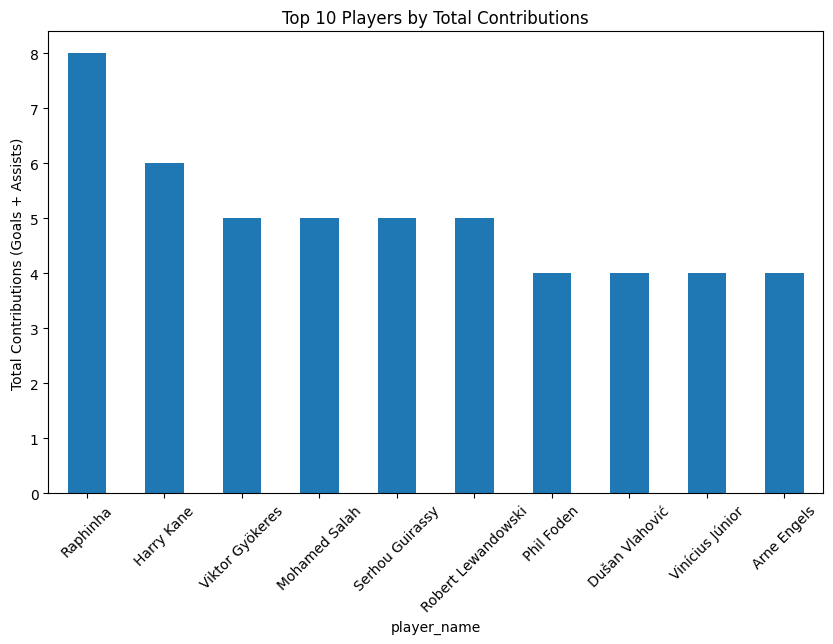

In [6]:
# Add a new column for total contributions
final_data['total_contributions'] = final_data['goals'] + final_data['assists']

# Top 10 players by total contributions
top_performers = final_data[['player_name', 'team', 'goals', 'assists', 'total_contributions']].sort_values(
    by='total_contributions', ascending=False).head(10)

print("--- Top 10 Players by Total Contributions ---")
print(top_performers)

# Bar chart for top performers
top_performers.plot(
    x='player_name', y='total_contributions', kind='bar', figsize=(10, 6), title='Top 10 Players by Total Contributions', legend=False
)
plt.ylabel('Total Contributions (Goals + Assists)')
plt.xticks(rotation=45)
plt.show()


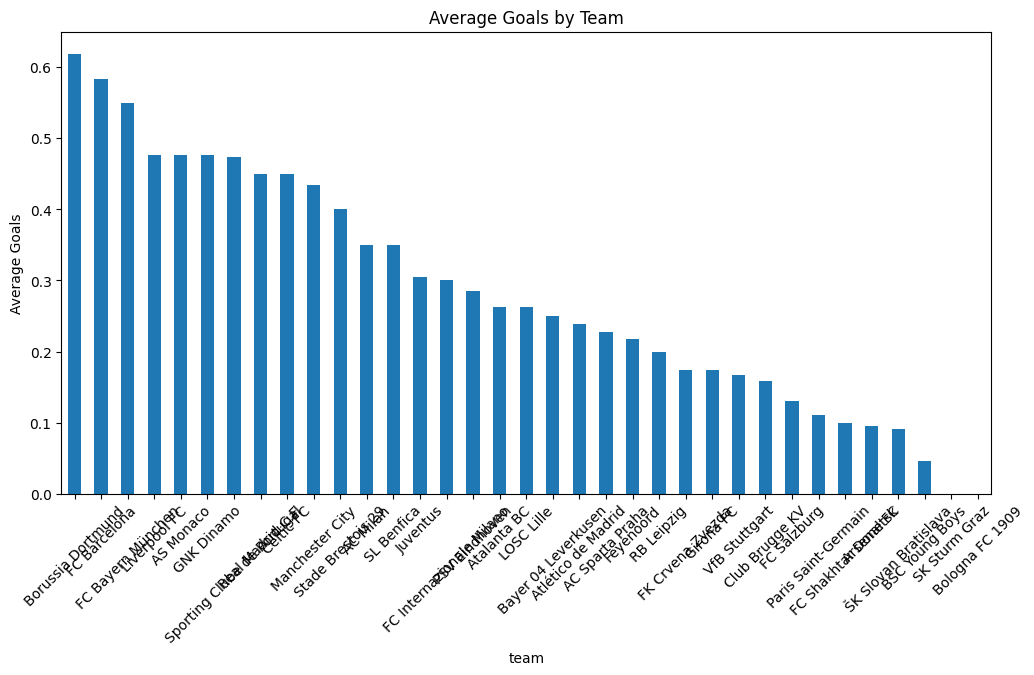

--- Team-Level Metrics ---
                               goals   assists  passing_accuracy(%)
team                                                               
Borussia Dortmund           0.619048  0.333333            78.000000
FC Barcelona                0.583333  0.583333            82.125000
FC Bayern München           0.550000  0.400000            89.500000
Liverpool FC                0.476190  0.428571            82.666667
AS Monaco                   0.476190  0.333333            81.380952
GNK Dinamo                  0.476190  0.333333            81.904762
Sporting Clube de Portugal  0.473684  0.368421            78.842105
Real Madrid C.F.            0.450000  0.150000            89.400000
Celtic FC                   0.450000  0.350000            80.100000
Manchester City             0.434783  0.304348            92.043478


In [7]:
# Aggregate team-level metrics
team_metrics = final_data.groupby('team')[['goals', 'assists', 'passing_accuracy(%)']].mean().sort_values(by='goals', ascending=False)

# Bar chart for team goals
team_metrics['goals'].plot(kind='bar', figsize=(12, 6), title='Average Goals by Team')
plt.ylabel('Average Goals')
plt.xticks(rotation=45)
plt.show()

# Display the table of team metrics
print("--- Team-Level Metrics ---")
print(team_metrics.head(10))  # Top 10 teams


C:\Users\heelt\AppData\Local\Temp\ipykernel_8416\1274201647.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_group_metrics = final_data.groupby('age_group')[['goals', 'assists']].mean()


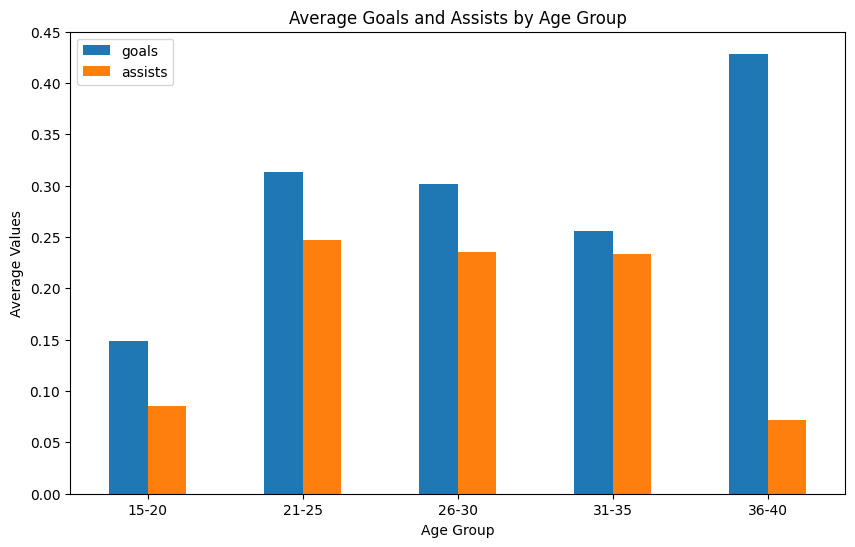

--- Metrics by Age Group ---
              goals   assists
age_group                    
15-20      0.148936  0.085106
21-25      0.313333  0.246667
26-30      0.301310  0.235808
31-35      0.255556  0.233333
36-40      0.428571  0.071429


In [8]:
# Create age groups
final_data['age_group'] = pd.cut(final_data['age'], bins=[15, 20, 25, 30, 35, 40], labels=['15-20', '21-25', '26-30', '31-35', '36-40'])

# Aggregate by age group
age_group_metrics = final_data.groupby('age_group')[['goals', 'assists']].mean()

# Bar chart for goals and assists by age group
age_group_metrics.plot(kind='bar', figsize=(10, 6), title='Average Goals and Assists by Age Group')
plt.ylabel('Average Values')
plt.xlabel('Age Group')
plt.xticks(rotation=0)
plt.show()

# Display the age group metrics
print("--- Metrics by Age Group ---")
print(age_group_metrics)


--- Top 10 Players by Total Contributions ---
            player_name                        team  goals  assists  \
155            Raphinha                FC Barcelona    5.0      3.0   
0            Harry Kane           FC Bayern München    5.0      1.0   
1       Viktor Gyökeres  Sporting Clube de Portugal    5.0      0.0   
126       Mohamed Salah                Liverpool FC    1.0      4.0   
200     Serhou Guirassy           Borussia Dortmund    3.0      2.0   
148  Robert Lewandowski                FC Barcelona    5.0      0.0   
170          Phil Foden             Manchester City    3.0      1.0   
150      Dušan Vlahović                    Juventus    3.0      1.0   
2       Vinícius Júnior            Real Madrid C.F.    4.0      0.0   
142         Arne Engels                   Celtic FC    1.0      3.0   

     total_contributions  
155                  8.0  
0                    6.0  
1                    5.0  
126                  5.0  
200                  5.0  
148       

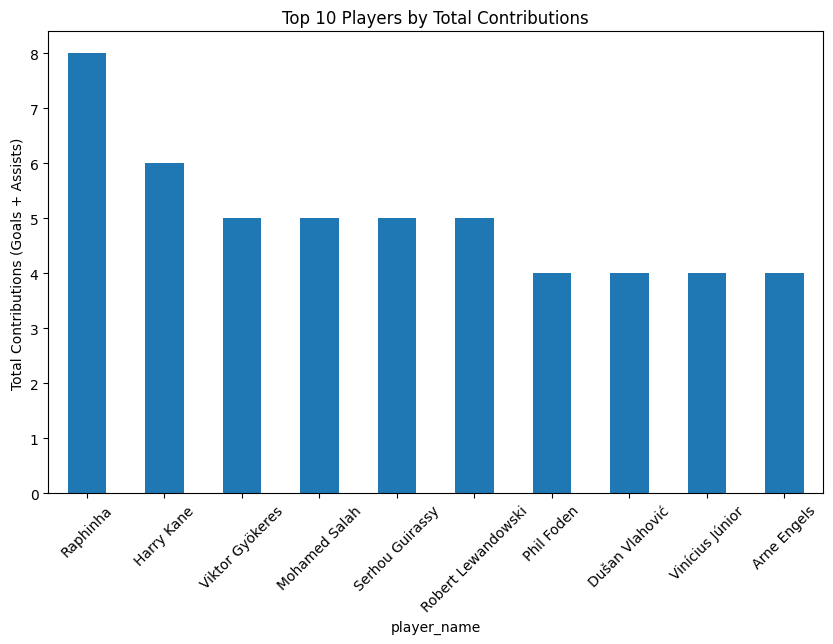

In [12]:
# Top 10 players by total contributions
top_contributors = final_data[['player_name', 'team', 'goals', 'assists', 'total_contributions']].sort_values(
    by='total_contributions', ascending=False).head(10)

print("--- Top 10 Players by Total Contributions ---")
print(top_contributors)

# Bar chart for top contributors
top_contributors.plot(
    x='player_name', y='total_contributions', kind='bar', figsize=(10, 6), title='Top 10 Players by Total Contributions', legend=False
)
plt.ylabel('Total Contributions (Goals + Assists)')
plt.xticks(rotation=45)
plt.show()


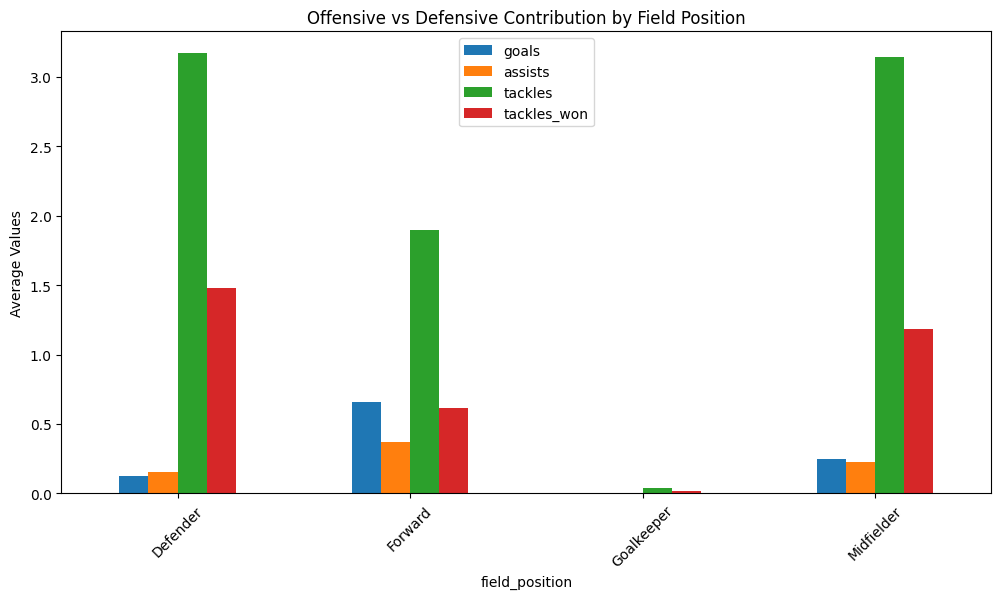

--- Offensive vs Defensive Contribution ---
                   goals   assists   tackles  tackles_won
field_position                                           
Defender        0.125506  0.153846  3.170040     1.477733
Forward         0.662577  0.368098  1.895706     0.613497
Goalkeeper      0.000000  0.000000  0.039216     0.019608
Midfielder      0.251880  0.225564  3.142857     1.187970


In [13]:
# Group by field position
position_contribution = final_data.groupby('field_position')[['goals', 'assists', 'tackles', 'tackles_won']].mean()

# Plot offensive vs defensive contributions
position_contribution.plot(kind='bar', figsize=(12, 6), title='Offensive vs Defensive Contribution by Field Position')
plt.ylabel('Average Values')
plt.xticks(rotation=45)
plt.show()

print("--- Offensive vs Defensive Contribution ---")
print(position_contribution)


In [14]:
# Step 1: Feature Engineering

# 1. Player Metrics
# Avoid division by zero with fillna(0) or replace where applicable
final_data['goals_per_match'] = (final_data['goals'] / final_data['matches_appearance']).fillna(0)
final_data['assists_per_match'] = (final_data['assists'] / final_data['matches_appearance']).fillna(0)
final_data['minutes_per_goal'] = (final_data['minutes_played'] / final_data['goals']).replace([float('inf'), float('nan')], 0)

# 2. Team Metrics
# Sum contributions by team
team_contributions = final_data.groupby('team').agg(
    total_goals=('goals', 'sum'),
    total_assists=('assists', 'sum'),
    total_attempts=('total_attempts', 'sum'),
    num_players=('id_player', 'count')
).reset_index()

# Calculate team efficiency and average player contributions
team_contributions['avg_player_contribution'] = (team_contributions['total_goals'] + team_contributions['total_assists']) / team_contributions['num_players']
team_contributions['team_efficiency'] = (team_contributions['total_goals'] / team_contributions['total_attempts']).fillna(0)

# Display player-level metrics and team metrics
print("--- Sample Player Metrics ---")
print(final_data[['player_name', 'goals_per_match', 'assists_per_match', 'minutes_per_goal']].head())

print("--- Team Metrics ---")
print(team_contributions.head())


--- Sample Player Metrics ---
         player_name  goals_per_match  assists_per_match  minutes_per_goal
0         Harry Kane             1.25               0.25              72.0
1    Viktor Gyökeres             1.25               0.00              72.0
2    Vinícius Júnior             1.00               0.00              90.0
3  Tijjani Reijnders             0.75               0.00             120.0
4  Maghnes Akliouche             0.50               0.25             180.0
--- Team Metrics ---
              team  total_goals  total_assists  total_attempts  num_players  \
0         AC Milan          7.0            6.0            54.0           25   
1  AC Sparta Praha          5.0            4.0            36.0           28   
2        AS Monaco         10.0            7.0            65.0           26   
3       Arsenal FC          2.0            2.0            47.0           30   
4      Atalanta BC          5.0            4.0            61.0           27   

   avg_player_contributi

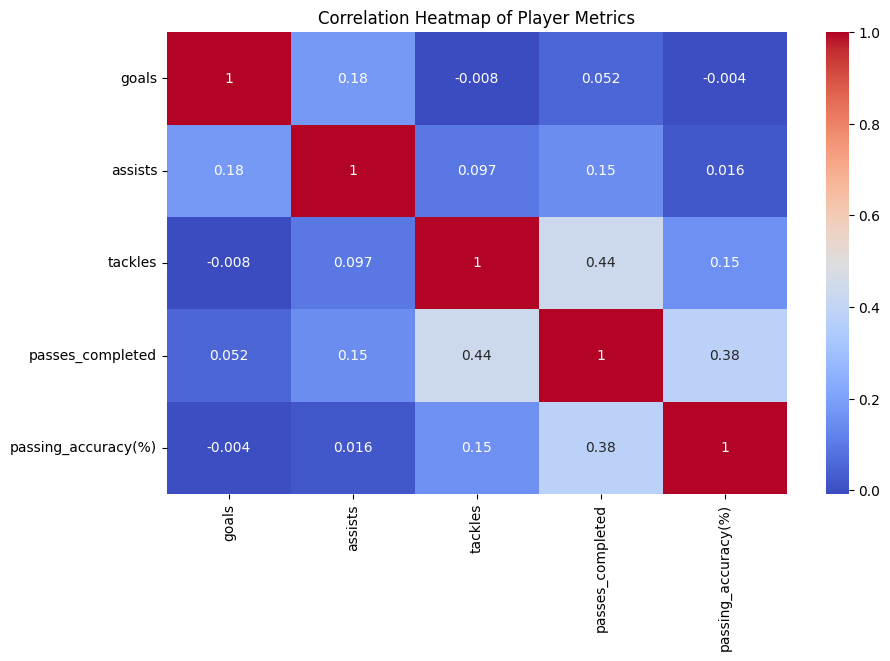

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation heatmap
correlation_matrix = final_data[['goals', 'assists', 'tackles', 'passes_completed', 'passing_accuracy(%)']].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Player Metrics')
plt.show()


c:\Program Files\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


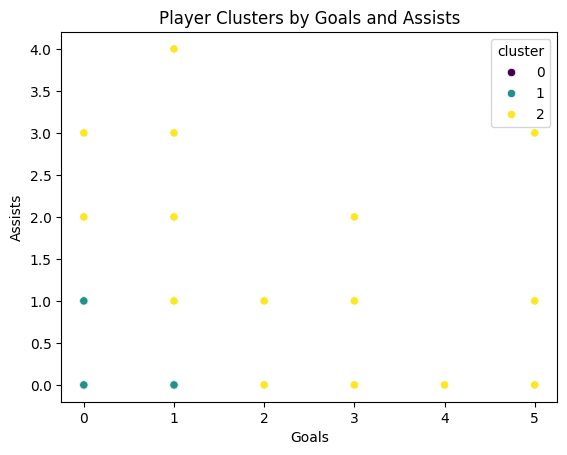

In [16]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Select performance metrics for clustering
player_metrics = final_data[['goals', 'assists', 'tackles', 'passes_completed']].fillna(0)

# Standardize the data
scaler = StandardScaler()
scaled_metrics = scaler.fit_transform(player_metrics)

# Perform K-Means clustering (e.g., 3 clusters)
kmeans = KMeans(n_clusters=3, random_state=42)
final_data['cluster'] = kmeans.fit_predict(scaled_metrics)

# Visualize the clusters using goals and assists
sns.scatterplot(
    x=final_data['goals'], 
    y=final_data['assists'], 
    hue=final_data['cluster'], 
    palette='viridis'
)
plt.title('Player Clusters by Goals and Assists')
plt.xlabel('Goals')
plt.ylabel('Assists')
plt.show()


In [18]:
import streamlit as st

# Example Player Stats
player_name = st.selectbox("Select a Player", final_data['player_name'].unique())
player_stats = final_data[final_data['player_name'] == player_name]

st.write(f"### {player_name}'s Stats")
st.write(player_stats[['goals', 'assists', 'minutes_per_goal', 'team']])


2024-12-14 20:23:44.834 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-14 20:23:44.836 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-14 20:23:44.837 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-14 20:23:44.838 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-14 20:23:44.838 WARNING streamlit.runtime.state.session_state_proxy: Session state does not function when running a script without `streamlit run`
2024-12-14 20:23:44.839 WARNING streamlit.runtime.scriptrunner_utils.script_run_c